In [1]:
import random
import numpy as np
import torch
from torch import nn
from typing import List

# from check_submission import check_submission
from game_mechanics import (
    PongEnv,
    human_player,
    load_network,
    play_pong,
    robot_choose_move,
    save_network,
    COURT_HEIGHT,
    COURT_WIDTH,
    BALL_RADIUS,
    PADDLE_HEIGHT,
    SWEET_SPOT_RADIUS
)

# Tom extra imports 
from tqdm import tqdm
import cProfile
from typing import Tuple
import scipy.ndimage
import copy
import matplotlib.pyplot as plt
from collections import deque

TEAM_NAME = "Quantum Chaos"  # <---- Enter your team name here!
assert TEAM_NAME != "Team Name", "Please change your TEAM_NAME!"

pygame 2.1.2 (SDL 2.0.18, Python 3.7.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Functions to load into Replit

In [9]:
# Testing torch operations

t1 = [torch.tensor([0.1, 2]), torch.tensor([3.00000, 4])]
t2 = [torch.tensor([0.12, 2.3]), torch.tensor([3.01, 4.02])]

def get_log10_fractional_update_of_params_lists(_pi: List[torch.Tensor],
                                                _pf : List[torch.Tensor]) -> List[float] :
    return [((_pf[_i] - _pi[_i]).std()/(_pi[_i]).std()).log10().item() for _i in range(len(_pi))]

print(get_log10_fractional_update_of_params_lists(t1,t2))

print([((t1[_i] - t2[_i]).std()/(t1[_i]).std()).log10().item() for _i in range(len(t1))])


[-0.8315955996513367, -2.000000476837158]
[-0.8315955996513367, -2.000000476837158]


In [25]:
n_inputs = 5
n_val_neurons = 10
V = nn.Sequential(
        nn.Linear(n_inputs, n_val_neurons),
        nn.LeakyReLU(),
        nn.Linear(n_val_neurons, 1),
        nn.Tanh(),
    )

x = torch.tensor([0.1,2,3,4,5])
print(x)
data_to_feed
for layer_index, module in enumerate(V.children()):
    data_to_feed = module(data_to_feed)
    print(f"layer {layer_index} output", data_to_feed)

tensor([0.1000, 2.0000, 3.0000, 4.0000, 5.0000])
layer 0 out tensor([ 3.6451,  0.3476, -1.0352,  1.0065, -0.8251, -0.3905,  1.1047, -0.9290,
         1.4380,  2.9136], grad_fn=<AddBackward0>)
layer 1 out tensor([ 3.6451,  0.3476, -0.0104,  1.0065, -0.0083, -0.0039,  1.1047, -0.0093,
         1.4380,  2.9136], grad_fn=<LeakyReluBackward0>)
layer 2 out tensor([-1.3878], grad_fn=<AddBackward0>)
layer 3 out tensor([-0.8827], grad_fn=<TanhBackward0>)


In [2]:
class ExperienceReplayMemory:
    def __init__(self, max_length: int):
        self.states = []
        self.actions = []
        self.rewards = []
        self.successor_states = []
        self.is_terminal = []
        self.max_length = max_length
        self._all_lists = [
            self.states,
            self.actions,
            self.rewards,
            self.successor_states,
            self.is_terminal,
        ]

    def append(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        successor_state: np.ndarray,
        is_terminal: bool,
    ):
        for l, item in zip(
            self._all_lists, [state, action, reward, successor_state, is_terminal]
        ):
            dtype = (
                bool
                if isinstance(item, bool)
                else int
                if isinstance(item, int)
                else torch.float32
            )
            l.append(torch.tensor(item, dtype=dtype))
            # If max length, remove the oldest states
            if len(l) > self.max_length:
                l.pop(0)

    def sample(self, size: int) -> Tuple[torch.Tensor, ...]:
        size = min(size, len(self.rewards))
        idxs = np.random.choice(len(self.rewards), replace = False, size = size) # this sped up runtime a ton 
        return tuple(torch.stack([l[idx] for idx in idxs]) for l in self._all_lists)

# A few functions for saving and observing things 
def get_log10_fractional_change_in_params(params0, params1):
    def conv_params_to_numpy(params):
        _p= [np.copy(_p.numpy()) for _p in params]
        return _p 
    params0_numpy = conv_params_to_numpy(params0)
    params1_numpy = conv_params_to_numpy(params1)
    return [np.log10(np.average(np.abs(_p1-_p0))/np.average(np.abs(_p0))) for _p1, _p0 in zip(params1_numpy,params0_numpy)]
def update_target(target: nn.Module, network: nn.Module): 
    # The code below also initializes a function which can update the target network to be the same as the current network:
    target.load_state_dict(network.state_dict())
    

def will_hit_top_edge(paddle_center_y: float, ball_y_at_paddle: float) -> bool:
    """Return True if the ball will hit the top edge of the paddle."""
    assert isinstance(
        paddle_center_y, (int, float)
    ), f"The paddle_center_y input to will_hit_top_edge should be a number, instead it's {paddle_center_y}"

    assert isinstance(
        ball_y_at_paddle, (int, float)
    ), f"The ball_y_at_paddle input to will_hit_top_edge should be a number, instead it's {ball_y_at_paddle}"

    return abs(ball_y_at_paddle - (paddle_center_y + (PADDLE_HEIGHT / 2))) < BALL_RADIUS


def will_hit_bottom_edge(paddle_center_y: float, ball_y_at_paddle: float) -> bool:
    """Return True if the ball will hit the bottom edge of the paddle."""
    return abs(ball_y_at_paddle - (paddle_center_y - (PADDLE_HEIGHT / 2))) < BALL_RADIUS


def will_hit_edge(paddle_center_y: float, ball_y_at_paddle: float) -> bool:
    """Return True if the ball will hit the top or bottom edge of the paddle."""
    return will_hit_top_edge(paddle_center_y, ball_y_at_paddle) or will_hit_bottom_edge(
        paddle_center_y, ball_y_at_paddle
    )


def will_hit_sweet_spot(paddle_center_y: float, ball_y_at_paddle: float) -> bool:
    """Return True if the ball will hit the sweet spot of the paddle."""
    return abs(paddle_center_y - ball_y_at_paddle) <= SWEET_SPOT_RADIUS

def will_hit_anywhere(paddle_center_y: float, ball_y_at_paddle: float) -> bool:
    """Return True if the ball will hit the sweet spot of the paddle."""
    return abs(paddle_center_y - ball_y_at_paddle) <= (PADDLE_HEIGHT /2.0  + BALL_RADIUS)


# Training process 

### Initialize network and hyperparameters

In [3]:
# Hyperparameters - given you some to narrow the search space
batch_size = 500  # Can be lowered if this is slow to run
max_memory_size = 40000 # should be chosen for reasonable forgetting time
frame_skip_num = 1 # how long to continue action after first choice 
learning_skip_num = 5 # how many steps to skip between learning network 
doubleDQN_skip_num = 20 # how many steps to skip before updating target_Q

In [4]:
# Initialize network
random_seed = 123923 # change random seed to get slightly different initial network
torch.manual_seed(random_seed) # will produce reproducible initalization

input_size = 22 #11
n_neurons1 = 128
n_neurons2 = 128
n_neurons3 = 128
output_size = 3
Q = nn.Sequential(
    nn.Linear(input_size, n_neurons1),
    nn.LeakyReLU(),
    nn.Linear(n_neurons1, n_neurons2),
    nn.LeakyReLU(),
    nn.Linear(n_neurons2, n_neurons3),
    nn.LeakyReLU(),
    nn.Linear(n_neurons3, output_size)
)

target_Q = copy.deepcopy(Q) # used for training target value, 
    # updated only periodically 

# Get parameters of network for debugging 
parameters = []
parameters_names = []
for _l, layer in enumerate(Q.children()):
    if isinstance(layer, nn.Linear):
        parameters.append(torch.flatten(layer.state_dict()['weight']))
        parameters_names.append('weights '+ str(_l) + ' ' + str(layer.state_dict()['weight'].numpy().transpose().shape))
        parameters.append(torch.flatten(layer.state_dict()['bias']))
        parameters_names.append('biases '+ str(_l) + ' ' + str(layer.state_dict()['bias'].numpy().transpose().shape))
print("Total parameters: ", sum(p.nelement() for p in parameters)) # number of parameters in total
for _p in parameters_names:
    print(_p)

Total parameters:  36355
weights 0 (22, 128)
biases 0 (128,)
weights 2 (128, 128)
biases 2 (128,)
weights 4 (128, 128)
biases 4 (128,)
weights 6 (128, 3)
biases 6 (3,)


### Run training

In [5]:
def choose_move(
    state: np.ndarray,
    neural_network: nn.Module,
) -> int:  # <--------------- Please do not change these arguments!
    with torch.no_grad():
        input_state = torch.tensor(conv_state_to_feat(state), dtype = torch.float)
        output_state = neural_network(input_state)
        greedy_action = torch.argmax(output_state).item() - 1.0 # subtract one to convert to -1,0,1
        greedy_action_int = int(greedy_action)    
    # return 1 if state[1] > state[3] else -1
    return greedy_action_int
    
def conv_act_to_ind(_act):
    # _act is in -1,0,1
    return _act + 1

def conv_state_to_feat(state: np.ndarray) -> np.ndarray:
    # ball angle is the angle of the ball’s motion, relative to the y-axis, clockwise, in degrees 
    
    self_ball_position_x = state[0]
    self_ball_position_y = state[1]
    self_ball_direction_radians = 2*np.pi*state[2]/360.0 -np.pi*3.0/2.0 # so now from 0 to 1
    self_paddle_self_centre_y = state[3] # self
    self_paddle_opponent_centre_y = state[4]
    self_ball_speed = state[5]/10.0
    self_ball_speed_x = self_ball_speed*np.cos(self_ball_direction_radians)
    self_ball_speed_y = self_ball_speed*np.sin(self_ball_direction_radians)

    # get predicted location of hit 
    ball_hit_loc_y_unfolded = self_ball_position_y+self_ball_position_x*np.tan(self_ball_direction_radians)
    
    # now fold back into 0 to 1 range
    def fold_val(_locUnnormed):
        _loc = _locUnnormed / COURT_HEIGHT
        lower = np.floor(_loc)
        remain = _loc - lower
        isOdd = 1.0 if (lower % 2) == 1 else 0.0
        effective_locUnnormed = remain*(1.0-isOdd) + (1.0-remain)*isOdd
        effective_loc = effective_locUnnormed * COURT_HEIGHT
        return effective_loc
    ball_hit_loc_y = fold_val(ball_hit_loc_y_unfolded)

    aboveOrBelowHitLoc_howmuch = np.tanh((ball_hit_loc_y-self_paddle_self_centre_y)/PADDLE_HEIGHT/2.0)
    aboveOrBelowHitLocTight_howmuch = np.tanh((ball_hit_loc_y-self_paddle_self_centre_y)/PADDLE_HEIGHT*2.0)
    aboveOrBelowHitTopEdge_howmuch = np.tanh((ball_hit_loc_y-(self_paddle_self_centre_y+PADDLE_HEIGHT/2.0))/BALL_RADIUS/1.0)
    aboveOrBelowHitBotEdge_howmuch = np.tanh((ball_hit_loc_y-(self_paddle_self_centre_y-PADDLE_HEIGHT/2.0))/BALL_RADIUS/1.0)
    crazyAngleAmount = np.tanh(np.tan(self_ball_direction_radians))*np.sign(self_ball_speed_x)
    
    # Have two feature vectors corresponding to choice when velocity is positive vs negative 
    featureVecReal = np.array([
        state[0]/COURT_WIDTH,
        state[1]/COURT_HEIGHT,
        state[3]/COURT_HEIGHT, # self
        state[4]/COURT_HEIGHT,
        self_ball_speed_x,
        self_ball_speed_y,
        aboveOrBelowHitLoc_howmuch,
        aboveOrBelowHitLocTight_howmuch,
        aboveOrBelowHitTopEdge_howmuch,
        aboveOrBelowHitBotEdge_howmuch,
        crazyAngleAmount
    ])
    featureVec0s = np.zeros(len(featureVecReal))
    if self_ball_speed_x > 0 : 
        featureVec = np.append(featureVec0s, featureVecReal)
    else : 
        featureVec = np.append(featureVecReal,featureVec0s)
    
    return featureVec

def choose_move_no_network(state) -> int:
        """The arguments in play_pong_game() require functions that only take the state as input.

        This converts choose_move() to that format.
        """
        return choose_move(state, neural_network=Q)

def play_pong_tom(
    your_choose_move,
    opponent_choose_move,
    n_points: int = 1,
    game_speed_multiplier: float = 1,
    verbose: bool = False,
    render: bool = False,
) -> int:
    """Play a game of pong where bat movement is controlled by `your_choose_move()`
    and `opponent_choose_move()`. You can display the game by setting verbose = True

    Args:
        your_choose_move: function that chooses move.
        opponent_choose_move: function that picks your opponent's next move
        n_points: how many points to play against your opponent
        game_speed_multiplier: multiplies the speed of the game. High == fast
        verbose: whether to print board states to console. Useful for debugging
        render: whether to render the game graphically with pygame

    Returns: total_return, which is the sum of return from the game
    """
    total_return = 0
    game = PongEnv(opponent_choose_move, render=render)

    for _ in range(n_points):
        observation, reward, done, info = game.reset()
        n = 0
        while not done:
            n += 1
            action = your_choose_move(observation)
            observation, reward, done, info = game.step(action)
            if reward == 10:
                total_return += 1
            elif reward == -10:
                total_return =0

    return total_return

def evaluate_against_robot(numGames):
    winCount = 0
    for _i in range(numGames):
        # # Play against your bot!!
        rew = play_pong_tom(
            your_choose_move=choose_move_no_network,
            opponent_choose_move=robot_choose_move,
            game_speed_multiplier=10000000,
            verbose=False,
            render=False,
        )
        winCount +=rew
    return float(winCount)/numGames
        

In [6]:
# reporting variables 
episodes_between_reports = 10

lenForAvgsOverEpisodes = episodes_between_reports
lenForAvgsOverSteps = episodes_between_reports*100
num_steps = []
total_rewards = deque(maxlen=lenForAvgsOverEpisodes)
hit_counts_any = deque(maxlen=lenForAvgsOverEpisodes)
avg_minqs = deque(maxlen=lenForAvgsOverSteps)
avg_maxqs = deque(maxlen=lenForAvgsOverSteps)
running_loss = []
running_steps = []
running_params_log10_frac_change = []

loss_fn = nn.MSELoss()

In [7]:
# Reinit memory
memory = ExperienceReplayMemory(max_length=max_memory_size)

In [89]:
trainEpochInds = [0,1,2]

for extraGlobalEpsilon, lrMultiplier in [[0.3, 1.0],
                                         [0.1, 0.75],
                                         [0.0, 0.5]]:
    for trainEpochInd in trainEpochInds:
        gamma0 = 0.999
        initial_steps_per_state = 10
        printHits = False
        initial_render = False
        turnOffHitReward = True
        gamma = gamma0**initial_steps_per_state

        if trainEpochInd == 0:
            print('')
            print('Training against robot')
            # Train against robot 

            max_num_episodes = 50 
            epsilon = 0.1 + extraGlobalEpsilon
            epsilon_decay = 1.0 - 2.0/max_num_episodes
            lr = 0.001*lrMultiplier

            opponent_function = robot_choose_move

            optim = torch.optim.Adam(Q.parameters(), lr=lr)

        elif trainEpochInd == 1:
            print('')
            print('Training against self')

            max_num_episodes = 50  
            epsilon = 0.1 + extraGlobalEpsilon
            epsilon_decay = 1.0 - 2.0/max_num_episodes
            lr = 0.0005*lrMultiplier

            # set up opponent 
            epsilon_opponent = epsilon+ 0.05
            def choose_move_opponent_self(state) -> int:
                if np.random.random() < epsilon_opponent:
                    action = np.random.randint(-1,2)
                else :
                    action =  choose_move(state, neural_network=Q)
                return action
            opponent_function = choose_move_opponent_self 

            optim = torch.optim.Adam(Q.parameters(), lr=lr)

        elif trainEpochInd == 2:
            print('')
            print('Training against self with no randomness in opponent')

            max_num_episodes = 50  
            epsilon = 0.05 + extraGlobalEpsilon
            epsilon_decay = 1.0 - 2.0/max_num_episodes
            lr = 0.0002*lrMultiplier

            # set up opponent 
            epsilon_opponent = 0.0
            def choose_move_opponent_self(state) -> int:
                if np.random.random() < epsilon_opponent:
                    action = np.random.randint(-1,2)
                else :
                    action =  choose_move(state, neural_network=Q)
                return action
            opponent_function = choose_move_opponent_self 

            optim = torch.optim.Adam(Q.parameters(), lr=lr)


        # Initialize environment
        env = PongEnv(opponent_choose_move=opponent_function, steps_per_state = initial_steps_per_state, render=initial_render)

        # Run training
        for episode_num in range(max_num_episodes):
            # Counts number of steps this episode
            n_steps = 0
            successor_state, reward, done, _ = env.reset()
            total_reward = 0
            hit_any_count = 0 

            epsilon *= epsilon_decay

            while not done:
                prev_state = successor_state.copy()
                if np.random.random() < epsilon:
                    action = np.random.randint(-1,2)
                elif n_steps % frame_skip_num == 0: # update action if frame 
                    with torch.no_grad():
                        action = choose_move(successor_state, Q)
                else:
                    action = action # keep it the same

                if n_steps % doubleDQN_skip_num  == 0:
                    # Update the Q target value function for learning 
                    update_target(target_Q, Q) 

                successor_state, reward, done, _ = env.step(action)
                if reward == 1.0:
                    hit_any_count += 1 
                if turnOffHitReward and reward == 1.0 :
                    reward = 0 

                memory.append(conv_state_to_feat(prev_state), action, reward, conv_state_to_feat(successor_state), done)

                with torch.no_grad():
                    input_state = torch.tensor(conv_state_to_feat(prev_state), dtype = torch.float)
                    qmin = torch.amin(Q(input_state)).item()
                    qmax = torch.amax(Q(input_state)).item()
                    avg_minqs.append(qmin)
                    avg_maxqs.append(qmax)

                if len(memory.rewards) >= batch_size and n_steps % learning_skip_num == 0: 
                    s1_features, a1, r1, s2_features, is_terminals = memory.sample(batch_size)

                    # Update steps
                    q_values_chosen_1 = Q(s1_features)[range(len(s1_features)), conv_act_to_ind(a1)]
                    with torch.no_grad():
                        # use current Q for action selection
                        chosen_successor_action = torch.argmax(Q(s2_features), dim=1)
                        # use stored target_Q for value evaluation (adds momentum to value learning)
                        max_q_successor = (
                            target_Q(s2_features)[range(len(s2_features)), chosen_successor_action] * ~is_terminals
                        )

                    # calculate loss 
                    with torch.no_grad():
                        parameters_before_update = [_p.clone().detach() for _p in parameters]
                    loss = loss_fn(q_values_chosen_1, r1 + gamma * max_q_successor)
                    running_loss.append(loss.item())
                    running_steps.append(n_steps)

                    # Updates the parameters!
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    with torch.no_grad():
                        parameters_after_update = [_p.clone().detach() for _p in parameters]
                        frac_change = get_log10_fractional_change_in_params(parameters_before_update, parameters_after_update)
                        running_params_log10_frac_change.append(frac_change)
                n_steps += 1
                total_reward += reward 

            # Used in debugging
            num_steps.append(n_steps)
            total_rewards.append(total_reward)
            hit_counts_any.append(hit_any_count)

            # Debugging
            if episode_num % episodes_between_reports == episodes_between_reports-1:
                print('---------------------')
                print("Avg total reward: ", np.round(np.average(np.array(total_rewards)),3), ' Avg steps: ', np.round(np.average(np.array(num_steps)),3))
                print("Avg hits:", np.round(np.average(np.array(hit_counts_any)),3))
                print('Avg qmin and qmax: ',  np.round(np.average(np.array(avg_minqs)),3), np.round(np.average(np.array(avg_maxqs)),3))
                print('Memory length (current): ', len(memory.rewards) )
                print('Epsilon: ', np.round(epsilon,4))
                ep_losses, num_steps = [], []

        print('---------------------')
        print('---------------------')
        print('End training epoch:')
        print('Wins against robot (10 games): ', evaluate_against_robot(10))
            
print('---------------------')
print('---------------------')
print('---------------------')
print('---DONE---')
print('Check against robot again... ')
print('Wins against robot at end (50 games): ', evaluate_against_robot(50))

Training against robot
---------------------
Avg total reward:  -8.0  Avg steps:  60.0
Avg hits: 0.5
Avg qmin and qmax:  -0.029 0.1
Memory length (current):  600
Epsilon:  0.2659
---------------------
Avg total reward:  -6.0  Avg steps:  132.0
Avg hits: 1.9
Avg qmin and qmax:  3.26 3.584
Memory length (current):  1920
Epsilon:  0.1768
---------------------
Avg total reward:  0.0  Avg steps:  269.6
Avg hits: 5.6
Avg qmin and qmax:  4.618 4.991
Memory length (current):  4616
Epsilon:  0.1175
---------------------
Avg total reward:  0.0  Avg steps:  261.4
Avg hits: 4.7
Avg qmin and qmax:  5.504 5.961
Memory length (current):  7230
Epsilon:  0.0781
---------------------
Avg total reward:  6.0  Avg steps:  227.2
Avg hits: 4.2
Avg qmin and qmax:  4.354 4.805
Memory length (current):  9502
Epsilon:  0.052
---------------------
---------------------
End training epoch:
Wins against robot (10 games):  0.9
Training against self
---------------------
Avg total reward:  6.0  Avg steps:  84.1
Avg h

### Observe results 

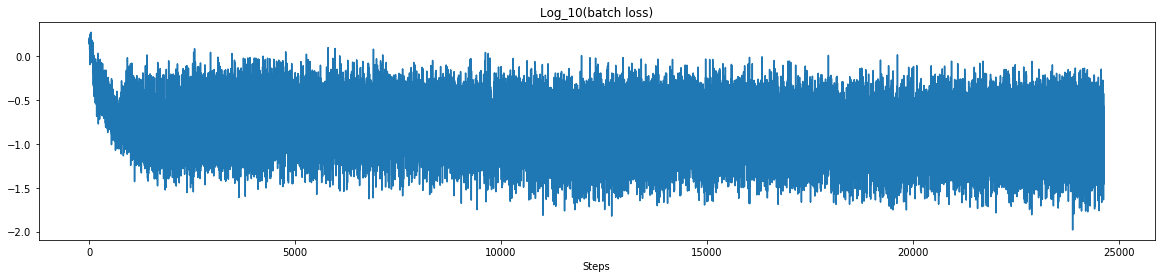

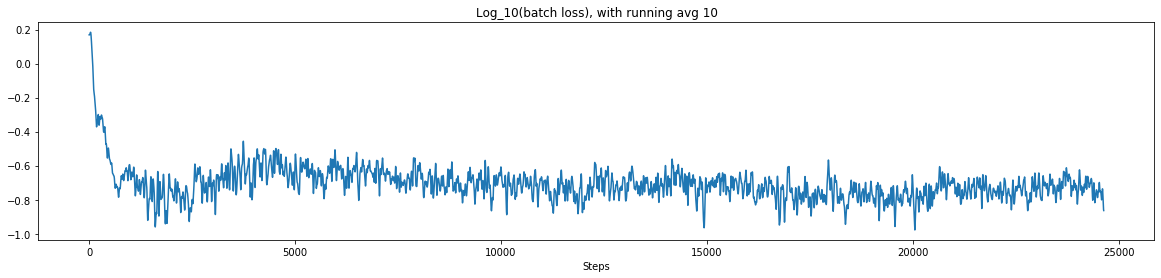

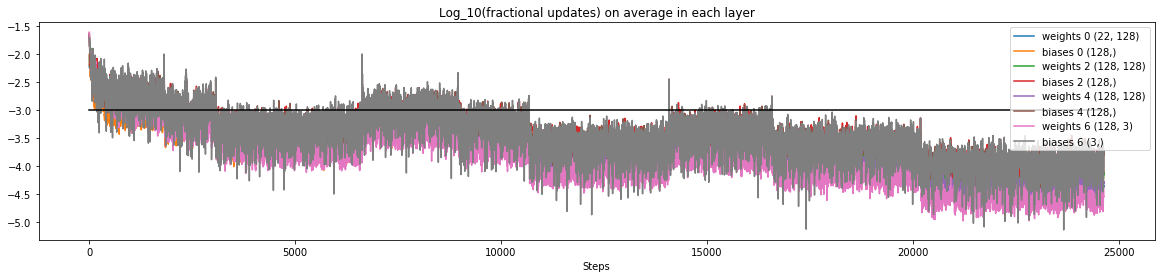

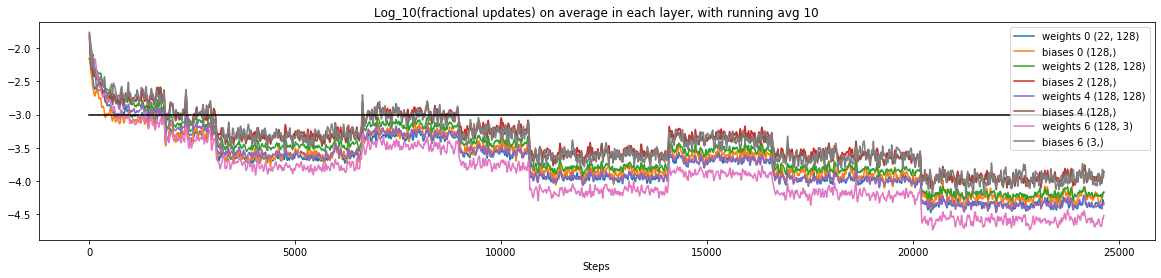

layer 0 (    Linear) input: mean +0.063372, std 4.713496e-01
layer 1 ( LeakyReLU) input: mean +0.027262, std 4.128831e-01
layer 2 (    Linear) input: mean +0.177552, std 2.326718e-01
layer 3 ( LeakyReLU) input: mean -0.251004, std 9.335114e-01
layer 4 (    Linear) input: mean +0.222386, std 3.111958e-01
layer 5 ( LeakyReLU) input: mean -1.432984, std 2.252469e+00
layer 6 (    Linear) input: mean +0.249723, std 4.691486e-01


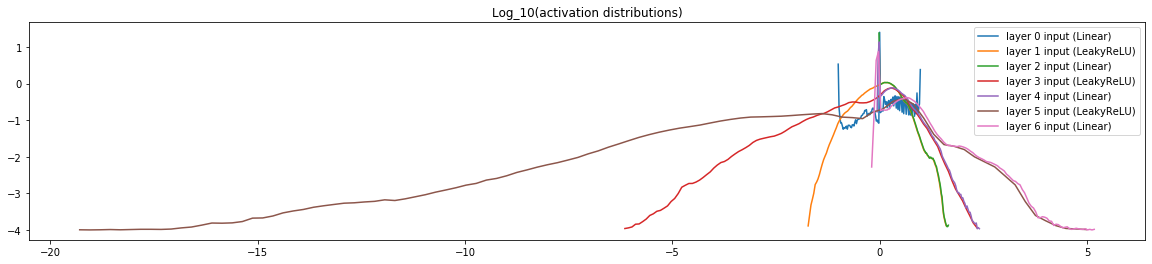

In [90]:
###############################################################
# Visualize training results vs training time 
###############################################################

running_avgYesNo = True
running_avgNum = 10

# Loss vs time 
plt.figure(figsize=(20, 4))
plt.plot(np.log10(running_loss))
plt.title('Log_10(batch loss)')
plt.xlabel('Steps')
plt.show()

if running_avgYesNo:
    plt.figure(figsize=(20, 4))
    plt.plot(np.log10(scipy.ndimage.gaussian_filter1d(running_loss, running_avgNum)))
    plt.title('Log_10(batch loss), with running avg ' + str(running_avgNum))
    plt.xlabel('Steps')
    plt.show()

# Layer update fractions vs time
running_params_log10_frac_change_plot = np.copy(np.array(running_params_log10_frac_change))
plt.figure(figsize=(20, 4))
legends = []
for _i in range(running_params_log10_frac_change_plot.shape[1]):
    plt.plot(running_params_log10_frac_change_plot[:,_i])
    legends.append(parameters_names[_i])
plt.plot([0, len(running_params_log10_frac_change_plot[:,0])], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('Log_10(fractional updates) on average in each layer')
plt.xlabel('Steps')    
plt.show()
if running_avgYesNo:
    plt.figure(figsize=(20, 4))
    legends = []
    for _i in range(running_params_log10_frac_change_plot.shape[1]):
        plt.plot(scipy.ndimage.gaussian_filter1d(running_params_log10_frac_change_plot[:,_i],running_avgNum))
        legends.append(parameters_names[_i])
    plt.plot([0, len(running_params_log10_frac_change_plot[:,0])], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends);
    plt.title('Log_10(fractional updates) on average in each layer, with running avg ' + str(running_avgNum))
    plt.xlabel('Steps')    
    plt.show()


###############################################################
# Histogram the gradients and activations at the end
###############################################################

# Get sample 
s1, a1, r1, s2, is_terminals = memory.sample(batch_size*200)

# Do forward pass to plot activations
with torch.no_grad():
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    
    xin = s1
    for _l, layer in enumerate(Q.children()):
        xout = layer(xin)
        epsilon_plot = 0.0001
        t = xin
        print('layer %d (%10s) input: mean %+f, std %e' % (_l, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), np.log10(hy.detach()+epsilon_plot))
        legends.append(f'layer {_l} input ({layer.__class__.__name__})')
        xin = xout
    plt.legend(legends);
    plt.title('Log_10(activation distributions)')
    plt.show()
    
# # Calculate gradients 
# q_values_chosen_1 = Q(s1)[range(len(s1)), conv_act_to_ind(a1)]
# with torch.no_grad():
#     chosen_successor_action = torch.argmax(Q(s2), dim=1)
#     max_q_successor = (
#         Q(s2)[range(len(s2)), chosen_successor_action] * ~is_terminals
#     )
# loss = loss_fn(q_values_chosen_1, r1 + gamma * max_q_successor)
# optim = torch.optim.Adam(Q.parameters(), lr=lr)
# optim.zero_grad()
# loss.backward()

# # Plot gradients of weights and biases 
# plt.figure(figsize=(20, 4)) # width and height of the plot
# legends = []
# for _l, layer in enumerate(Q.children()):
#     for param in layer.parameters():
#         t = param.grad
#         epsilon_plot = 1
#         #print('layer %d (%10s): mean %+f, std %e' % (_l, layer.__class__.__name__, t.mean(), t.std()))
#         print('weights/biases %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(param.shape), t.mean(), t.std(), t.std() / param.std()))
#         hy, hx = torch.histogram(t, density=True)
#         plt.plot(hx[:-1].detach(),  np.log10(hy.detach()+epsilon_plot))
#         legends.append(f'layer {_l} ({layer.__class__.__name__})')
# plt.legend(legends);
# plt.title('Log_10(weights/biases gradient distribution)');
# plt.show()

In [61]:
# # Play against your bot!!
play_pong(
    your_choose_move=human_player,
    opponent_choose_move=choose_move_no_network,
    game_speed_multiplier=10,
    verbose=False,
    render=True,
)

-50

In [93]:
# # Play bot against bot!!
play_pong(
    your_choose_move=choose_move_no_network,
    opponent_choose_move=choose_move_no_network,
    game_speed_multiplier=50,
    verbose=False,
    render=True,
)

11

# Save network and run checks 

In [92]:
# my_network = Q 
# save_network(my_network, TEAM_NAME)

In [8]:
# reload network 
Q = load_network(TEAM_NAME)

In [ ]:
# # Play against your bot!!
play_pong(
    your_choose_move=human_player,
    opponent_choose_move=choose_move_no_network,
    game_speed_multiplier=10,
    verbose=False,
    render=True,
)

In [ ]:
# # Play bot against bot!!
play_pong(
    your_choose_move=choose_move_no_network,
    opponent_choose_move=choose_move_no_network,
    game_speed_multiplier=100,
    verbose=False,
    render=True,
)

In [ ]:

# # # Make sure this does not error! Or your
# # submission will not work in the tournament!
# check_submission(TEAM_NAME)

# my_network = load_network(TEAM_NAME)

# #  Code below plays a single game of pong against a basic robot player
# #  opponent, think about how you might want to adapt this to
# #  test the performance of your algorithm.
# def choose_move_no_network(state) -> int:
#     """The arguments in play_pong_game() require functions that only take the state as input.

#     This converts choose_move() to that format.
#     """
#     return choose_move(state, neural_network=my_network)

# # # Play against your bot!!
# play_pong(
#     your_choose_move=human_player,
#     opponent_choose_move=choose_move_no_network,
#     game_speed_multiplier=10,
#     verbose=True,
#     render=True,
# )